# Exploring digitised maps in Trove

If you've ever poked around in Trove's 'map' zone, you might have noticed the beautiful deep-zoomable images available for many of the NLA's digitised maps. Even better, in many cases the high-resolution TIFF versions of the digitised maps are available for download.

I knew there were lots of great maps you could download from Trove, but how many? And how big were the files? I thought I'd try to quantify this a bit by harvesting and analysing the metadata.

The size of the downloadable files (both in bytes and pixels) are [embedded within the landing pages](https://nbviewer.jupyter.org/github/GLAM-Workbench/trove-books/blob/master/Metadata-for-Trove-digitised-works.ipynb) for the digitised maps. So harvesting the metadata involves a number of steps:

* Use the Trove API to search for maps that include the phrase "nla.obj" – this will filter the results to maps that have been digitised and are available through Trove
* Work through the results, checking to see if the record includes a link to a digital copy.
* If there is a digital copy, extract the embedded work data from the landing page.
* Sometimes the work data doesn't include the copyright status, if it doesn't then I scrape it from the page.

Here's the [downloaded metadata as a CSV formatted file](single_maps.csv). You can also [browse the results](https://docs.google.com/spreadsheets/d/1yBPcCk9wIRovRacKbfrlyThWrzGXLF79Lr0GIQbaO9Y/edit?usp=sharing) using Google Sheets.

## Setting things up

In [16]:
import requests
from tqdm import tqdm_notebook
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from IPython.display import display, FileLink
import re
import json
import time
import pandas as pd
from bs4 import BeautifulSoup
import altair as alt

s = requests.Session()
retries = Retry(total=5, backoff_factor=1, status_forcelist=[ 502, 503, 504 ])
s.mount('https://', HTTPAdapter(max_retries=retries))
s.mount('http://', HTTPAdapter(max_retries=retries))

alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## You'll need a Trove API key to harvest the data.

In [ ]:
api_key = ''

## Define some functions to do the work

In [9]:
def get_total_results(params):
    '''
    Get the total number of results for a search.
    '''
    these_params = params.copy()
    these_params['n'] = 0
    response = s.get('https://api.trove.nla.gov.au/v2/result', params=these_params)
    data = response.json()
    return int(data['response']['zone'][0]['records']['total'])


def get_fulltext_url(links):
    '''
    Loop through the identifiers to find a link to the digital version of the journal.
    '''
    url = None
    for link in links:
        if link['linktype'] == 'fulltext' and 'nla.obj' in link['value']:
            url = link['value']
            break
    return url

def get_copyright_status(response):
    '''
    Scrape copyright information from a digital work page.
    '''
    soup = BeautifulSoup(response.text, 'lxml')
    copyright_status = soup.find('div', id='tab-access').strong.string
    return copyright_status

def get_work_data(url):
    '''
    Extract work data in a JSON string from the work's HTML page.
    '''
    response = s.get(url)
    try:
        work_data = json.loads(re.search(r'var work = JSON\.parse\(JSON\.stringify\((\{.*\})', response.text).group(1))
    except (AttributeError, TypeError):
        work_data = '{}'
    else:
        # If there's no copyright info in the work data, then scrape it
        if 'copyrightPolicy' not in work_data:
            work_data['copyrightPolicy'] = get_copyright_status(response)
    return work_data

def format_bytes(size):
    # 2**10 = 1024
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'K', 2: 'M', 3: 'G', 4: 'T'}
    while size > power:
        size /= power
        n += 1
    return size, power_labels[n]+'B'

def get_map_data(work_data):
    '''
    Look for file size information in the embedded data
    '''
    map_data = {}
    width = None
    height = None
    num_bytes = None
    try:
        # Make sure there's a downloadable version
        if work_data.get('accessConditions') == 'Unrestricted' and 'copies' in work_data:
            for copy in work_data['copies']:
                # Get the pixel dimensions
                if 'technicalmetadata' in copy:
                    width = copy['technicalmetadata'].get('width')
                    height = copy['technicalmetadata'].get('height')
                # Get filesize in bytes
                elif copy['copyrole'] in ['m', 'o', 'i', 'fd'] and copy['access'] == 'true':
                    num_bytes = copy.get('filesize')
            if width and height and num_bytes:
                size, unit = format_bytes(num_bytes)
                # Convert bytes to something human friendly
                map_data['filesize_string'] = '{:.2f}{}'.format(size, unit)
                map_data['filesize'] = num_bytes
                map_data['width'] = width
                map_data['height'] = height
                map_data['copyright_status'] = work_data.get('copyrightPolicy')
    except AttributeError:
        pass
    return map_data
                

def get_maps():
    '''
    Harvest metadata about maps.
    '''
    url = 'http://api.trove.nla.gov.au/v2/result'
    maps = []
    params = {
        'q': '"nla.obj-"',
        'zone': 'map',
        'l-availability': 'y',
        'l-format': 'Map/Single map',
        'bulkHarvest': 'true', # Needed to maintain a consistent order across requests
        'key': api_key,
        'n': 100,
        'encoding': 'json'
    }
    start = '*'
    total = get_total_results(params)
    with tqdm_notebook(total=total) as pbar:
        while start:
            params['s'] = start
            response = s.get(url, params=params)
            data = response.json()
            # If there's a startNext value then we get it to request the next page of results
            try:
                start = data['response']['zone'][0]['records']['nextStart']
            except KeyError:
                start = None
            for work in tqdm_notebook(data['response']['zone'][0]['records']['work'], leave=False):
                # Check to see if there's a link to a digital version
                try:
                    fulltext_url = get_fulltext_url(work['identifier'])
                except KeyError:
                    pass
                else:
                    if fulltext_url:
                        work_data = get_work_data(fulltext_url)
                        map_data = get_map_data(work_data)
                        if 'filesize' in map_data:
                            trove_id = re.search(r'(nla\.obj\-\d+)', fulltext_url).group(1)
                            try:
                                contributors = '|'.join(work.get('contributor'))
                            except TypeError:
                                contributors = work.get('contributor')
                            # Get basic metadata
                            # You could add more work data here
                            # Check the Trove API docs for work record structure
                            map_data['title'] = work['title']
                            map_data['fulltext_url'] = fulltext_url
                            map_data['trove_url'] = work.get('troveUrl')
                            map_data['trove_id'] = trove_id
                            map_data['date'] = work.get('issued')
                            map_data['creators'] = contributors
                            maps.append(map_data)
                            time.sleep(0.2)
            time.sleep(0.2)
            pbar.update(100)
    return maps

## Download map data

In [ ]:
maps = get_maps()

## Convert to dataframe and save to CSV

In [ ]:
# Convert to dataframe
df = pd.DataFrame(maps)
df.head()

In [29]:
# Save to CSV
df.to_csv('single_maps.csv', index=False)
display(FileLink('single_maps.csv'))

/Users/tim/mycode/glam-workbench/trove-maps/notebooks/single_maps.csv

## Let's explore the results

In [28]:
# Reload data from CSV if necessary
df = pd.read_csv('single_maps.csv')

How many single maps have high-resolution downloads?

In [30]:
print('{:,} maps'.format(df.shape[0]))

20,158 maps


How much map data is available for download?

In [31]:
size, unit = format_bytes(df['filesize'].sum())
print('{:.2f}{}'.format(size, unit))

7.07TB


What's the copyright status of the maps?

In [32]:
df['copyright_status'].value_counts()

Out of Copyright                   14967
In Copyright                        3271
No known copyright restrictions     1506
Edition Out of Copyright             245
Copyright Undetermined               148
Edition In Copyright                  12
Unknown                                6
Perpetual                              2
Copyright Uncertain                    1
Name: copyright_status, dtype: int64

Let's show the copyright status as a chart...

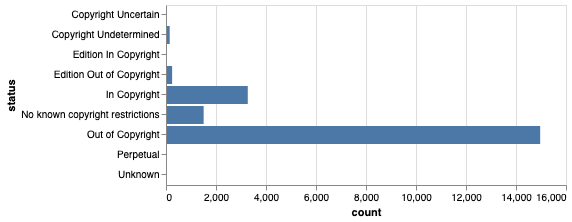

In [14]:
counts = df['copyright_status'].value_counts().to_frame().reset_index()
counts.columns = ['status', 'count']
alt.Chart(counts).mark_bar().encode(
    y='status:N',
    x='count',
    tooltip='count'
)

Let's look at the sizes of the download files.

So while most are less than 500MB, almost 5,000 are between 0.5 and 1GB!

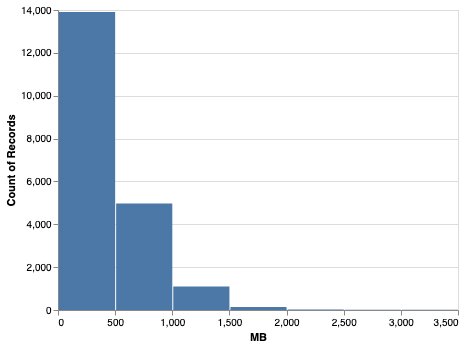

In [21]:
df['mb'] = df['filesize'] / 2**10 / 2**10
alt.Chart(df).mark_bar().encode(
    x=alt.X('mb', bin=True, title='MB'),
    y='count()',
    tooltip='count()'
)

What's the biggest file available for download?

In [22]:
df.iloc[df['filesize'].idxmax()]

copyright_status                      No known copyright restrictions
creators                                   Geological Survey of India
date                                                             1932
filesize                                                   3623879488
filesize_string                                                3.38GB
fulltext_url                      http://nla.gov.au/nla.obj-591001246
height                                                          38023
title               Map of the City of Rangoon and suburbs 1928-29...
trove_id                                            nla.obj-591001246
trove_url                     https://trove.nla.gov.au/work/182743876
width                                                           31769
mb                                                               3456
Name: 3017, dtype: object

All downloads greater than 3GB.

In [25]:
df.loc[(df['filesize'] / 2**10 / 2**10 / 2**10) > 3]

,copyright_status,creators,date,filesize,filesize_string,fulltext_url,height,title,trove_id,trove_url,width,mb
1218,Out of Copyright,"Imray, James F. (James Frederick), 1829?-1891",1853-1863,3388748804,3.16GB,http://nla.gov.au/nla.obj-390032889,24785,"Chart of the west, south and east coasts of Au...",nla.obj-390032889,https://trove.nla.gov.au/work/13684619,45575,3231.762699
3017,No known copyright restrictions,Geological Survey of India,1932,3623879488,3.38GB,http://nla.gov.au/nla.obj-591001246,38023,Map of the City of Rangoon and suburbs 1928-29...,nla.obj-591001246,https://trove.nla.gov.au/work/182743876,31769,3456.000793
4578,In Copyright,Indonesia. Direktorat Geologi,1970,3279210576,3.05GB,http://nla.gov.au/nla.obj-568387103,41429,Peta geologi teknik daerah Jakarta - Bogor : E...,nla.obj-568387103,https://trove.nla.gov.au/work/20208553,26384,3127.298904
4830,No known copyright restrictions,Taiwan,1942,3264456500,3.04GB,http://nla.gov.au/nla.obj-400826638,25508,Nyūginia-tō zenzu / Taiwan Sōtokufu Gaijibu...,nla.obj-400826638,https://trove.nla.gov.au/work/205481810,42659,3113.228321
7237,In Copyright,Indonesia. Direktorat Geologi,1963,3311801600,3.08GB,http://nla.gov.au/nla.obj-568387099,20990,Geological map of Djawa and Madura / compiled ...,nla.obj-568387099,https://trove.nla.gov.au/work/218208895,52593,3158.380127
19858,Out of Copyright,South Australia. Surveyor-General's Office,1885-1950,3308608288,3.08GB,http://nla.gov.au/nla.obj-230705067,43121,Plan shewing pastoral leases and claims in the...,nla.obj-230705067,https://trove.nla.gov.au/work/8818311,25576,3155.334747


The widest image?

In [26]:
df.iloc[df['width'].idxmax()]

copyright_status                                         In Copyright
creators                               Brunei Shell Petroleum Company
date                                                             1968
filesize                                                   3008938460
filesize_string                                                2.80GB
fulltext_url                      http://nla.gov.au/nla.obj-636346192
height                                                          14652
title               Land status petroleum mining agreement in resp...
trove_id                                            nla.obj-636346192
trove_url                     https://trove.nla.gov.au/work/230363372
width                                                           68453
mb                                                            2869.55
Name: 8165, dtype: object

The tallest image?

In [27]:
df.iloc[df['height'].idxmax()]

copyright_status                                     Out of Copyright
creators                   South Australia. Surveyor-General's Office
date                                                        1885-1950
filesize                                                   3308608288
filesize_string                                                3.08GB
fulltext_url                      http://nla.gov.au/nla.obj-230705067
height                                                          43121
title               Plan shewing pastoral leases and claims in the...
trove_id                                            nla.obj-230705067
trove_url                       https://trove.nla.gov.au/work/8818311
width                                                           25576
mb                                                            3155.33
Name: 19858, dtype: object

----

Created by [Tim Sherratt](https://timsherratt.org/).

Work on this notebook was supported by the [Humanities, Arts and Social Sciences (HASS) Data Enhanced Virtual Lab](https://tinker.edu.au/).
